# State Level Comparisons

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
try:
    # read directly from NYT's github repo for the freshest data
    states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
except:
    # unless it's not available in which case read locally after pulling the repo from upstream
    # (assumes you've added the NYT repo as upstream with 
    #     $ remote add upstream https://github.com/nytimes/covid-19-data.git)
    !git pull upstream master
    states = pd.read_csv('us-states.csv')

In [113]:
states.drop(columns='fips',inplace=True)
states.head()

,date,state,cases,deaths
0,2020-01-21,Washington,1,0
1,2020-01-22,Washington,1,0
2,2020-01-23,Washington,1,0
3,2020-01-24,Illinois,1,0
4,2020-01-24,Washington,1,0


In [114]:
# compute the new cases and new deaths per state
start = '2020-01-20'
los = states.state.unique()
for state in los:
    tmp = pd.concat([pd.DataFrame([{'state': state, 'date': start, 'cases': 0, 'deaths': 0}]),states[states.state == state]])
    # compute new cases and deaths
    states.loc[tmp.index,'new_cases'] = tmp['cases'] - tmp['cases'].shift(1)
    states.loc[tmp.index,'new_deaths'] = tmp['deaths'] - tmp['deaths'].shift(1)

In [124]:
states.head()

,date,state,cases,deaths,new_cases,new_deaths
0,2020-01-21,Washington,1,0,NaN,NaN
1,2020-01-22,Washington,1,0,0.0,0.0
2,2020-01-23,Washington,1,0,0.0,0.0
3,2020-01-24,Illinois,1,0,1.0,0.0
4,2020-01-24,Washington,1,0,0.0,0.0


In [139]:
# function to space the tick labels on the x axis and optionally rotate them
def space_x_ticks(ax,n,rotation=0):
    xticks=ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i%n != 0:
            xticks[i].set_visible(False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=rotation)

In [153]:
# function to make a 2x2 grid of plots showing new and total cases and deaths for a list of states
def compare_states(los):
    tmp = states.loc[states.state.isin(los)]
    
    #find the earliest date when any state in the list had 10 total cases
    start = tmp.loc[tmp.cases >= 10,'date'].min()
    tmp = tmp[tmp.date >= start]
    fig, ax = plt.subplots(2, 2, sharex='col',figsize=(10,8))
    fig.suptitle('COVID-19 Counts', fontsize=14, y=1.02);
    plt.tight_layout(pad=0.4, w_pad=0, h_pad=1.0)
    
    # top left
    sns.lineplot(x=tmp.date,y=tmp.new_cases,hue=tmp.state,ax=ax[0,0])
    ax[0,0].set_ylabel('Cases')
    ax[0,0].set_title('New per Day')
    ax[0,0].set_yscale('log')
    ax[0,0].get_xaxis().set_visible(False)
    
    # top right
    sns.lineplot(x=tmp.date,y=tmp.cases,hue=tmp.state,ax=ax[0,1],legend=False)
    ax[0,1].get_yaxis().label.set_visible(False)
    ax[0,1].set_title('Total')
    ax[0,1].set_yscale('log')
    ax[0,1].get_xaxis().set_visible(False)
    
    # bottom left
    sns.lineplot(x=tmp.date,y=tmp.new_deaths,hue=tmp.state,ax=ax[1,0],legend=False)
    ax[1,0].set_ylabel('Deaths')
    ax[1,0].set_yscale('log')
    space_x_ticks(ax[1,0],7,45)
    
    # bottom right
    sns.lineplot(x=tmp.date,y=tmp.deaths,hue=tmp.state,ax=ax[1,1],legend=False)
    ax[1,1].get_yaxis().label.set_visible(False)
    ax[1,1].set_yscale('log')
    space_x_ticks(ax[1,1],7,45)

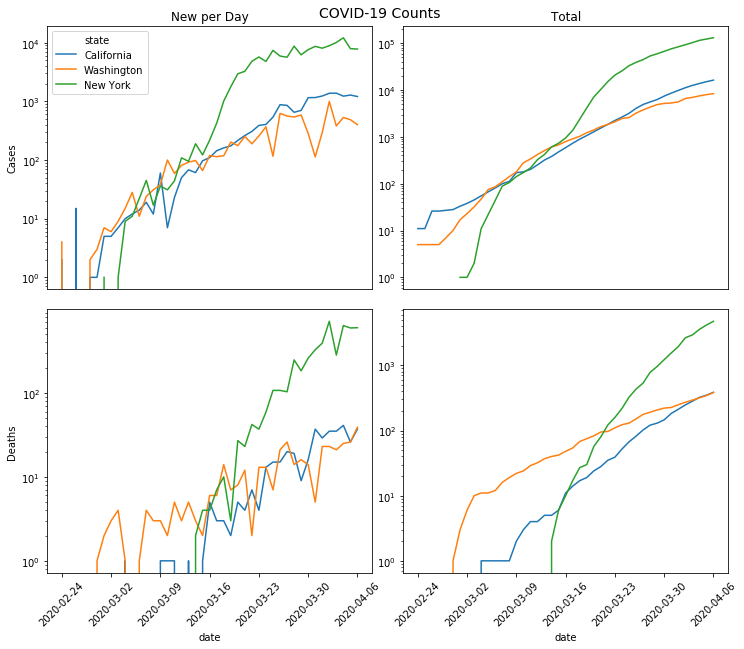

In [154]:
compare_states(['California','New York','Washington'])

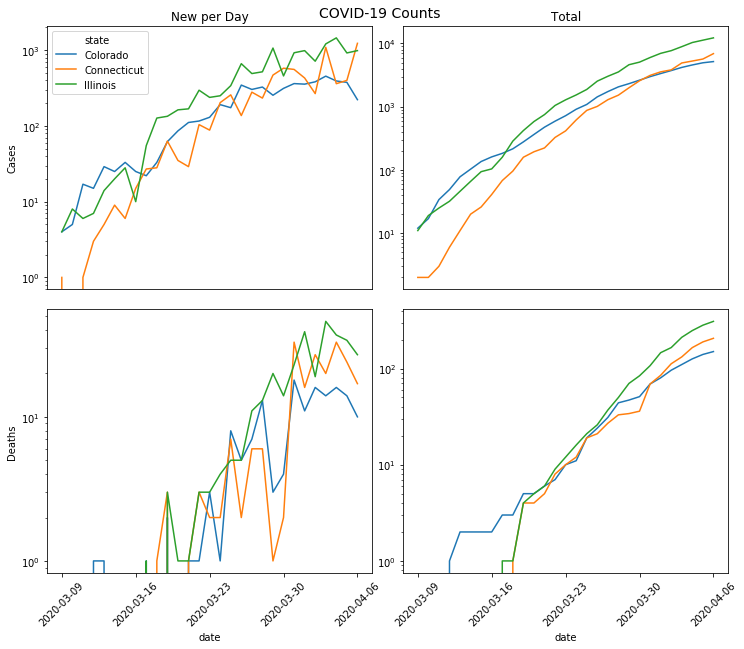

In [155]:
compare_states(['Connecticut','Colorado','Illinois'])

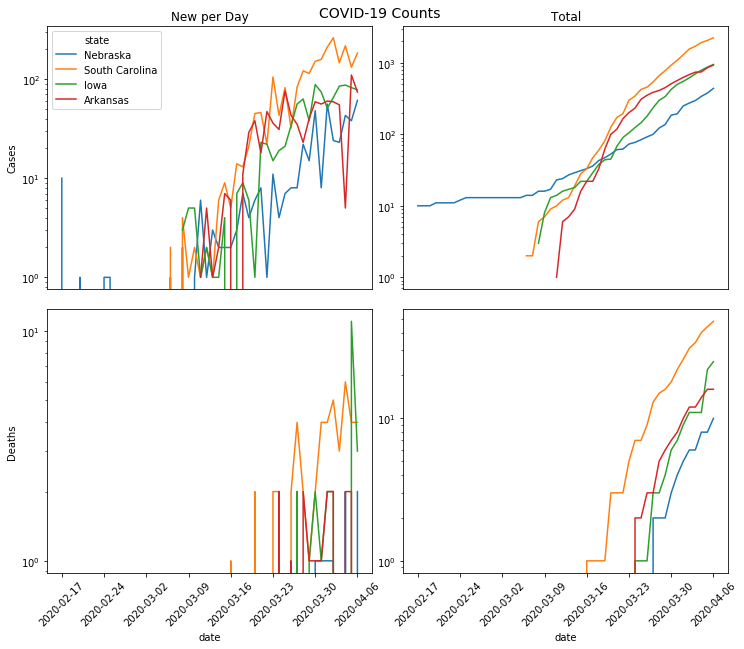

In [156]:
compare_states(['Arkansas', 'Iowa', 'Nebraska', 'South Carolina'])

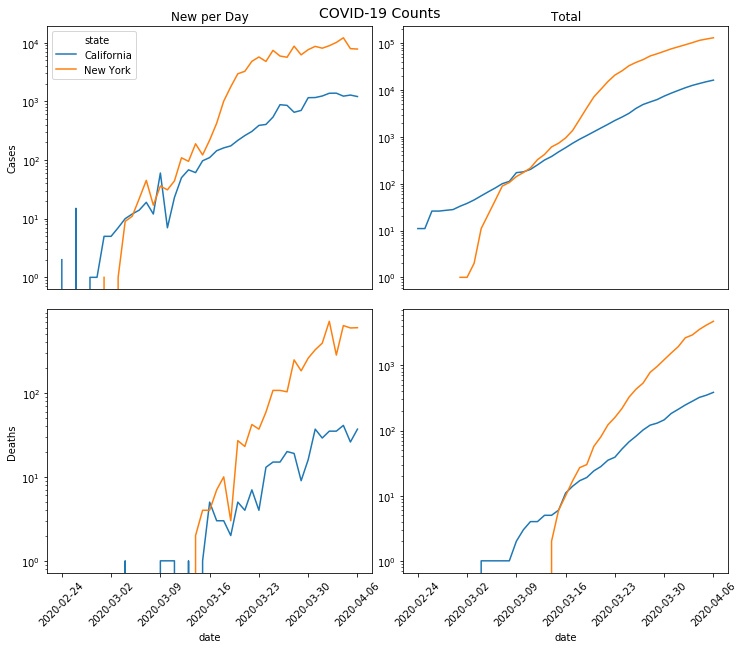

In [157]:
compare_states(['California','New York'])

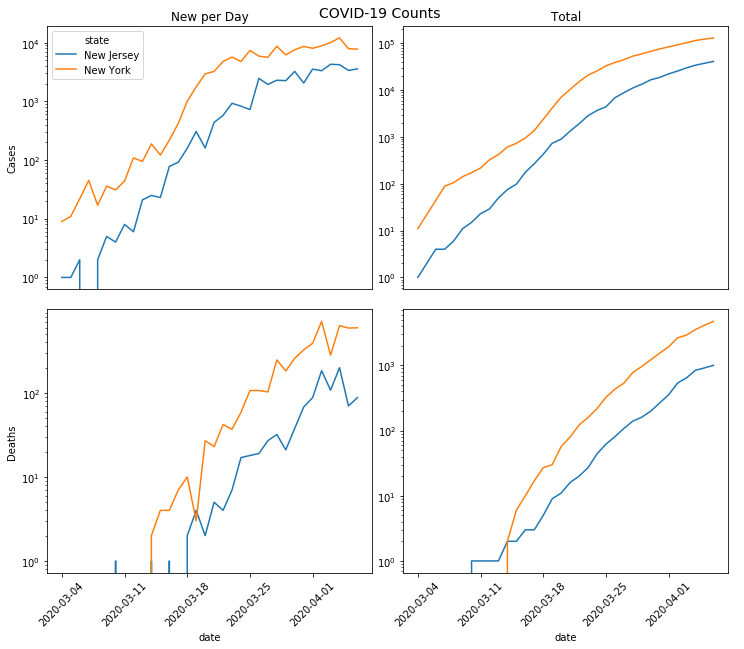

In [158]:
compare_states(['New York','New Jersey'])

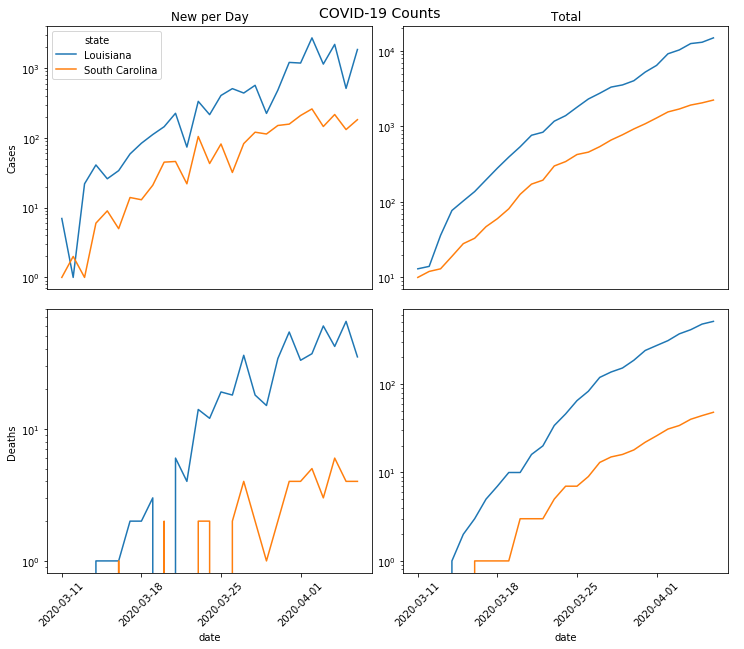

In [159]:
compare_states(['Louisiana','South Carolina'])

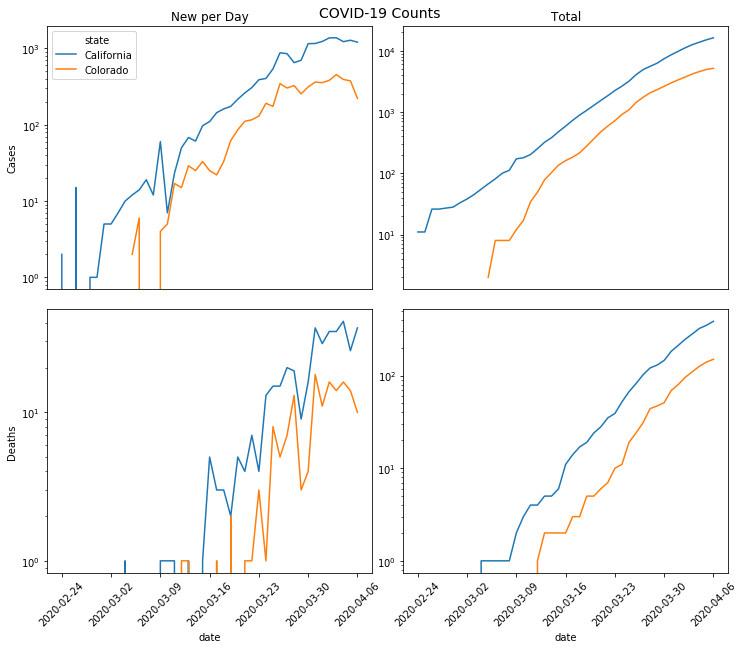

In [160]:
compare_states(['California','Colorado'])

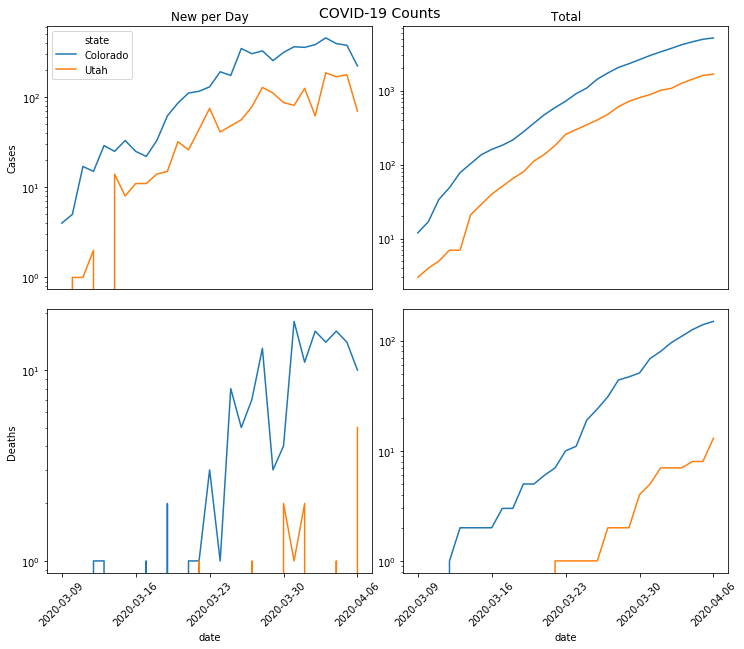

In [161]:
compare_states(['Utah','Colorado'])